# Sprint 3 — HMDA Data Analysis & Modeling (ADSP Track)

# 1.0 Project Overview


## 1.1 Objective
- Predict loan approval outcomes from HMDA data.
- Identify patterns, ratios, and county-level trends that may indicate market opportunities.


## 1.2 Research Questions
- What borrower/property features most influence approval?
- Which states and counties show unusually high or low approval patterns?
- Do engineered ratios create meaningful predictive power?



## 1.3 Workflow
- Load → Clean → Engineer Features → Split → Model → Evaluate → Interpret


# 2.0 Setup & Data Import

## Load Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier


plt.rcParams["figure.figsize"] = (10,5)
sns.set_theme(style="whitegrid") 


## Set Display Options


## Load Raw HMDA Dataset

In [2]:
# load dataset 2024_public_LAR
file_path = file_path = 'C:\\Users\\jtqua\\OneDrive\\Desktop\\INST414(0202) Data Science Techniques\\capstone folder\\2024_public_lar_csv.csv'



## Initial Inspect (shape, head, dtypes)

In [3]:

df = pd.read_csv(file_path, nrows=5)
print(len(df.columns))
print(df.columns.tolist())

99
['activity_year', 'lei', 'derived_msa_md', 'state_code', 'county_code', 'census_tract', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'derived_ethnicity', 'derived_race', 'derived_sex', 'action_taken', 'purchaser_type', 'preapproval', 'loan_type', 'loan_purpose', 'lien_status', 'reverse_mortgage', 'open_end_line_of_credit', 'business_or_commercial_purpose', 'loan_amount', 'combined_loan_to_value_ratio', 'interest_rate', 'rate_spread', 'hoepa_status', 'total_loan_costs', 'total_points_and_fees', 'origination_charges', 'discount_points', 'lender_credits', 'loan_term', 'prepayment_penalty_term', 'intro_rate_period', 'negative_amortization', 'interest_only_payment', 'balloon_payment', 'other_nonamortizing_features', 'property_value', 'construction_method', 'occupancy_type', 'manufactured_home_secured_property_type', 'manufactured_home_land_property_interest', 'total_units', 'multifamily_affordable_units', 'income', 'debt_to_income_ratio', 'applicant_

In [ ]:
# Count total rows in the dataset
with open(file_path, 'r', encoding='utf-8') as f:
    total_rows = sum(1 for line in f) - 1
print(f"Total rows in dataset: {total_rows:,}")

Total rows in dataset: 12,229,298


# 3.0 Data Filtering & Subsetting

## select an equal proportion of each state. drop unwanted columns 

In [5]:
# create a stratified sample of the HMDA dataset by state_code

# The goal of this stratified sampling approach is to create a representative but much smaller version of the HMDA dataset, small enough to work with in a Jupyter notebook or data science workflow, while still preserving the state-level distribution of loans.

# Instead of taking a random 0.1% of the entire dataset (which could heavily under-represent small states), this method ensures that each state contributes 0.1% of its own total loan records.

# This produces a sample that reflects reality within each state, not dominated by large states like CA or TX.


# -------------------------------------------------------------
# USER SETTINGS
# -------------------------------------------------------------
sample_fraction = 0.001              # 0.1% sample (0.001 = 0.1%)
random_state = 42                    # For reproducibility

# =============================================================
# STEP 1: READ ONLY 'state_code' TO COMPUTE HOW MANY ROWS 
#         TO SAMPLE FROM EACH STATE
# =============================================================

# We read only the 'state_code' column. This is much faster than loading the
# entire multi-GB file.
state_only = pd.read_csv(file_path, usecols=['state_code'])

# value_counts() counts how many rows belong to each state.
# Example output: CA = 1,300,000 rows; TX = 900,000; etc.
state_counts = (
    state_only.value_counts()            # count occurrences of each state
              .reset_index(name='count') # convert to DataFrame with a column named 'count'
)

# Add a new column: how many rows we want to sample from each state.
# Example: if CA has 1,300,000 rows, 0.1% = 1,300 rows.
state_counts['remaining_n'] = (
    state_counts['count'] * sample_fraction
).round().astype(int)

# Set the state_code column as the index for easy lookup later.
state_counts = state_counts.set_index('state_code')

print("Target number of samples per state - number of rows your algorithm will extract from each state.:")
print(state_counts['remaining_n'].sort_values(ascending=False).head())


# =============================================================
# STEP 2: STREAM THROUGH CSV IN CHUNKS AND SAMPLE PROPORTIONALLY
# =============================================================

samples = []  # a list to store sampled chunks

# We now read the giant dataset in manageable chunks of 50,000 rows.
# This avoids loading a 10+ GB file into memory.
for chunk in pd.read_csv(file_path, chunksize=50000, low_memory=False):

    # ------------------------------------------
    # Filter the chunk:
    # We only keep rows belonging to states that STILL need samples.
    # If a state already reached its quota, skip it.
    # ------------------------------------------
    states_still_needed = state_counts[state_counts['remaining_n'] > 0].index
    chunk = chunk[chunk['state_code'].isin(states_still_needed)]

    # If chunk becomes empty after filtering, skip to next chunk.
    if chunk.empty:
        continue

    # ------------------------------------------
    # Group rows by state inside the chunk
    # ------------------------------------------
    # chunk.groupby('state_code') creates separate groups for each state.
    # Example: all CA rows in this chunk, all TX rows in this chunk, etc.
    for state, group in chunk.groupby('state_code'):

        # 'group' is a DataFrame containing ONLY rows of that one state
        # Example: all CA rows in the current chunk.

        # How many more rows do we still need for this state?
        need = state_counts.loc[state, 'remaining_n']

        # We cannot sample more rows than the number available in this chunk.
        take = min(len(group), need)

        # If we still need some rows:
        if take > 0:
            # sample(n=take) randomly selects exactly 'take' rows.
            sampled_rows = group.sample(n=take, random_state=random_state)
            samples.append(sampled_rows)

            # Reduce the remaining quota for this state.
            state_counts.loc[state, 'remaining_n'] -= take


# =============================================================
# STEP 3: COMBINE ALL SAMPLED PIECES INTO ONE DATAFRAME
# =============================================================

hmda_sample = pd.concat(samples, ignore_index=True)

print("Final sample shape:", hmda_sample.shape)

# Save to disk
hmda_sample.to_csv("hmda_stratified_sample.csv", index=False)


Target number of samples per state - number of rows your algorithm will extract from each state.:
state_code
TX    1069
FL    1045
CA    1024
NC     494
GA     478
Name: remaining_n, dtype: int32
Final sample shape: (12015, 99)


In [6]:
#Remove Duplicate Records
# ---------------------------
num_duplicates = hmda_sample.duplicated().sum()
print(f"Initial duplicates: {num_duplicates}")

# Drop exact duplicates
hmda_sample = hmda_sample.drop_duplicates()

# Confirm removal
num_duplicates_after = hmda_sample.duplicated().sum()
print(f"Remaining duplicates: {num_duplicates_after}")
print(f"Final dataset shape: {hmda_sample.shape}")

print([col for col in hmda_sample.columns if 'Unnamed' in col])

Initial duplicates: 1
Remaining duplicates: 0
Final dataset shape: (12014, 99)
[]



# 4.0 Exploratory Data Analysis (EDA)

## Basic Summary Statistics

In [ ]:
# Create Binary Target Variable 'approved' from 'action_taken'
hmda_sample["approved"] = hmda_sample["action_taken"].apply(lambda x: 1 if x == 1 else 0)
hmda_sample["approved"].value_counts(normalize=True)
# hmda_sample.info()

approved
0    0.632928
1    0.367072
Name: proportion, dtype: float64

In [14]:
# --- Define all selected variables chart showing all data info and selection---
cols_to_show = [
    # Location & Market Context
    'state_code', 'county_code', 'census_tract',
    'tract_population', 'tract_owner_occupied_units',
    'tract_one_to_four_family_homes', 'tract_median_age_of_housing_units',
    'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage',

    # Loan Characteristics
    'derived_loan_product_type', 'loan_type', 'loan_purpose', 'purchaser_type',
    'preapproval', 'lien_status', 'reverse_mortgage', 'open_end_line_of_credit',
    'business_or_commercial_purpose', 'loan_term', 'intro_rate_period',

    # Loan Performance & Decision Outcomes
    'action_taken', 'denial_reason_1', 'denial_reason_2',
    'denial_reason_3', 'denial_reason_4', 'hoepa_status',

    # Loan Amount & Financial Terms
    'loan_amount', 'combined_loan_to_value_ratio', 'interest_rate', 'rate_spread',
    'total_loan_costs', 'total_points_and_fees', 'origination_charges',
    'discount_points', 'lender_credits',

    # Property Attributes
    'property_value', 'construction_method', 'derived_dwelling_category',
    'occupancy_type', 'manufactured_home_secured_property_type',
    'manufactured_home_land_property_interest', 'total_units',
    'multifamily_affordable_units',

    # Applicant Financial Profile
    'income', 'debt_to_income_ratio', 'applicant_credit_score_type',
    'co_applicant_credit_score_type',

    # Applicant Age & Lifecycle Indicators
    'applicant_age', 'co_applicant_age',
    'applicant_age_above_62', 'co_applicant_age_above_62'
]

# --- Create the base variable inventory ---
inventory = pd.DataFrame({
    'Variable Name': cols_to_show,
    'Data Type': [hmda_sample[col].dtype for col in cols_to_show],
    'Missing %': [hmda_sample[col].isna().mean() * 100 for col in cols_to_show]
})

# --- Dictionary of descriptions ---
descriptions = {
    'state_code': 'Two-letter US state code where the property is located',
    'county_code': 'FIPS code for the county',
    'census_tract': 'Census tract number where the property is located',
    'tract_population': 'Total population in the census tract',
    'tract_owner_occupied_units': 'Number of owner-occupied housing units in the tract',
    'tract_one_to_four_family_homes': 'Number of 1–4 family homes in the tract',
    'tract_median_age_of_housing_units': 'Median age of housing units in the tract (years)',
    'ffiec_msa_md_median_family_income': 'Median family income of the MSA/MD (from FFIEC data)',
    'tract_to_msa_income_percentage': 'Ratio of tract median income to MSA/MD median income (%)',
    'derived_loan_product_type': 'Type of loan product (e.g., conventional, FHA, VA)',
    'loan_type': 'Loan type: conventional, FHA, VA, RHS',
    'loan_purpose': 'Purpose of loan (home purchase, refinance, etc.)',
    'purchaser_type': 'Type of entity purchasing the loan (investor or agency)',
    'preapproval': 'Whether the applicant had preapproval for the loan',
    'lien_status': 'Lien position: first or subordinate',
    'reverse_mortgage': 'Whether the loan is a reverse mortgage',
    'open_end_line_of_credit': 'Whether the loan is an open-end line of credit',
    'business_or_commercial_purpose': 'Loan for business or commercial purposes',
    'loan_term': 'Loan term in months (e.g., 360)',
    'intro_rate_period': 'Introductory fixed-rate period for adjustable loans (months)',
    'action_taken': 'HMDA action taken code (loan originated, denied, withdrawn, etc.)',
    'denial_reason_1': 'Primary reason for denial of the loan',
    'denial_reason_2': 'Secondary reason for denial',
    'denial_reason_3': 'Third reason for denial',
    'denial_reason_4': 'Fourth reason for denial',
    'hoepa_status': 'Whether the loan is subject to HOEPA (high-cost mortgage)',
    'loan_amount': 'Original loan amount in dollars',
    'combined_loan_to_value_ratio': 'Combined loan-to-value ratio (%)',
    'interest_rate': 'Annual interest rate (%)',
    'rate_spread': 'Difference between loan rate and average prime offer rate',
    'total_loan_costs': 'Total loan costs paid by borrower',
    'total_points_and_fees': 'Total points and fees paid by borrower',
    'origination_charges': 'Charges for originating the loan',
    'discount_points': 'Discount points paid to reduce interest rate',
    'lender_credits': 'Lender credits applied to borrower',
    'property_value': 'Appraised value of the property',
    'construction_method': 'Construction type (site-built, modular, manufactured)',
    'derived_dwelling_category': 'Dwelling category (single family, multifamily)',
    'occupancy_type': 'Occupancy type: owner-occupied, rental, or second home',
    'manufactured_home_secured_property_type': 'Type of property for manufactured homes',
    'manufactured_home_land_property_interest': 'Land ownership type for manufactured home property',
    'total_units': 'Number of units in the property',
    'multifamily_affordable_units': 'Number of affordable units in multifamily property',
    'income': "Borrower's reported annual income ($)",
    'debt_to_income_ratio': "Borrower's debt-to-income ratio (%)",
    'applicant_credit_score_type': 'Type of applicant credit score reported',
    'co_applicant_credit_score_type': 'Type of co-applicant credit score reported',
    'applicant_age': "Borrower's age",
    'co_applicant_age': "Co-borrower's age",
    'applicant_age_above_62': 'Indicator if borrower is older than 62',
    'co_applicant_age_above_62': 'Indicator if co-borrower is older than 62'
}

# --- Map descriptions ---
inventory['Description'] = inventory['Variable Name'].map(descriptions)

# --- Add placeholder for relevance and mark key variables ---
inventory['Relevance (★ Key Vars)'] = ''
key_vars = ['census_tract', 'tract_population', 'loan_amount', 'state_code', 'action_taken', 'income', 'debt_to_income_ratio', 'county_code', 'loan_type', 'denial_reason_1', 'applicant_age', 'applicant_age_above_62']
inventory.loc[inventory['Variable Name'].isin(key_vars), 'Relevance (★ Key Vars)'] = '★'

# --- Reorder columns for readability ---
inventory = inventory[['Variable Name','Data Type','Description','Relevance (★ Key Vars)','Missing %']]

# --- Display full inventory in Jupyter ---
pd.set_option('display.max_rows', None)
display(inventory)


,Variable Name,Data Type,Description,Relevance (★ Key Vars),Missing %
0,state_code,object,Two-letter US state code where the property is...,★,0.000000
1,county_code,float64,FIPS code for the county,★,0.000000
2,census_tract,float64,Census tract number where the property is located,★,0.000000
3,tract_population,int64,Total population in the census tract,★,0.000000
4,tract_owner_occupied_units,int64,Number of owner-occupied housing units in the ...,,0.000000
5,tract_one_to_four_family_homes,int64,Number of 1–4 family homes in the tract,,0.000000
6,tract_median_age_of_housing_units,int64,Median age of housing units in the tract (years),,0.000000
7,ffiec_msa_md_median_family_income,int64,Median family income of the MSA/MD (from FFIEC...,,0.000000
8,tract_to_msa_income_percentage,float64,Ratio of tract median income to MSA/MD median ...,,0.000000
9,derived_loan_product_type,object,"Type of loan product (e.g., conventional, FHA,...",,0.000000


In [15]:
# Remove Extra Columns
extra_cols = [col for col in hmda_sample.columns if col not in cols_to_show]
print(f"Extra columns not being used ({len(extra_cols)}):\n", extra_cols)

hmda_sample = hmda_sample.drop(columns=extra_cols, errors='ignore')
print("Cleaned dataset shape:", hmda_sample.shape)


Extra columns not being used (0):
 []
Cleaned dataset shape: (12014, 51)


In [16]:
# 4. Exploratory Data Analysis (EDA) shows missing columns
# --- Variable Inventory ---
inventory = pd.DataFrame({
    'Variable Name': hmda_sample.columns,
    'Data Type': hmda_sample.dtypes,
    'Missing %': hmda_sample.isna().mean() * 100
})

# Show the variable inventory sorted by missing %
print(inventory.sort_values(by='Missing %', ascending=False).to_string(index=False))

                           Variable Name Data Type  Missing %
                   total_points_and_fees   float64 100.000000
            multifamily_affordable_units   float64  99.941735
                         denial_reason_4   float64  99.908440
                         denial_reason_3   float64  99.384052
                         denial_reason_2   float64  96.703846
                       intro_rate_period   float64  80.905610
                          lender_credits   float64  77.035126
               co_applicant_age_above_62    object  73.023140
                         discount_points   float64  71.474946
                             rate_spread   float64  66.131180
                    debt_to_income_ratio    object  52.047611
            combined_loan_to_value_ratio   float64  51.464958
                                  income   float64  40.036624
                  applicant_age_above_62    object  37.647744
                        total_loan_costs   float64  33.552522
        

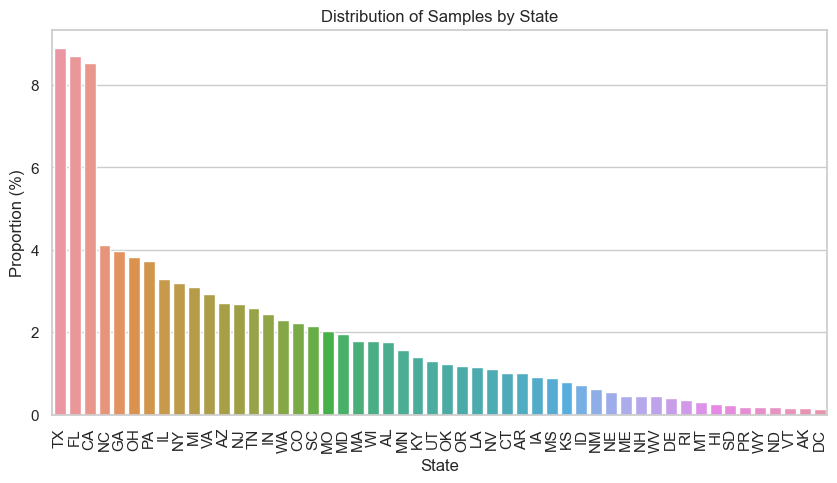

In [17]:
# plot total proportion of loan applications per state

# --- State Distribution ---
state_dist = hmda_sample['state_code'].value_counts(normalize=True) * 100
state_dist_df = state_dist.reset_index()
state_dist_df.columns = ['State', 'Proportion (%)']

# Display state distribution table
# display(state_dist_df)

# visualize the state distribution
# plt.figure(figsize=(12,6))
sns.barplot(x='State', y='Proportion (%)', data=state_dist_df)
plt.xticks(rotation=90)
plt.title('Distribution of Samples by State')
plt.show()


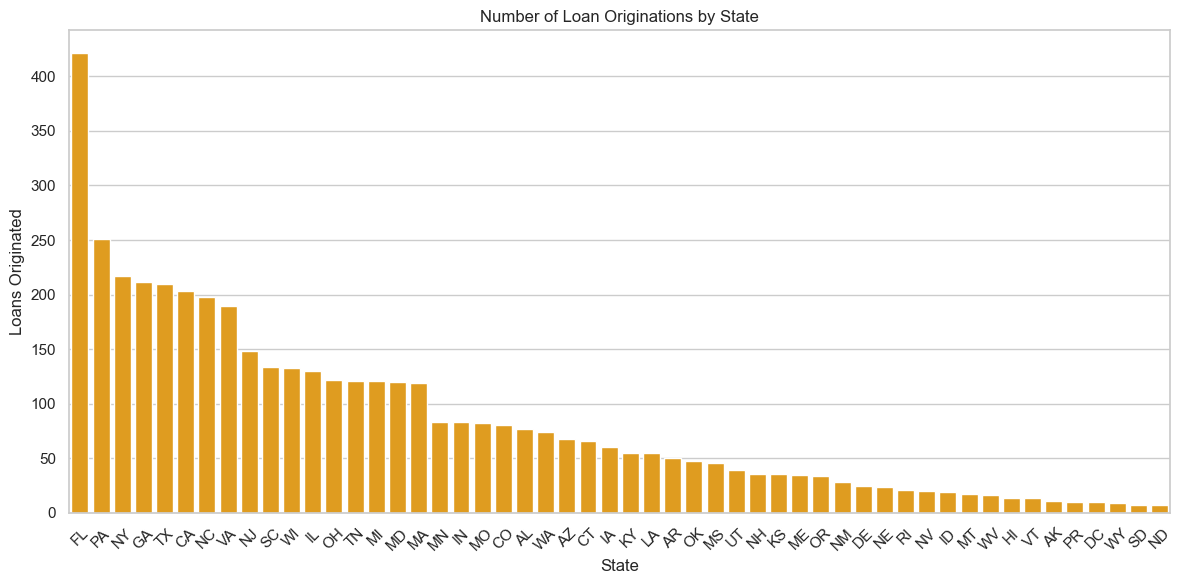

In [18]:
# Loans Originated by State
# ------------------------------

originated = hmda_sample[hmda_sample['action_taken'] == 1]

state_counts_originated = (
    originated['state_code']
    .value_counts()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12,6))
sns.barplot(
    x=state_counts_originated.index,
    y=state_counts_originated.values,
    color='#FFA500'   # ORANGE
)
plt.title('Number of Loan Originations by State')
plt.xlabel('State')
plt.ylabel('Loans Originated')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


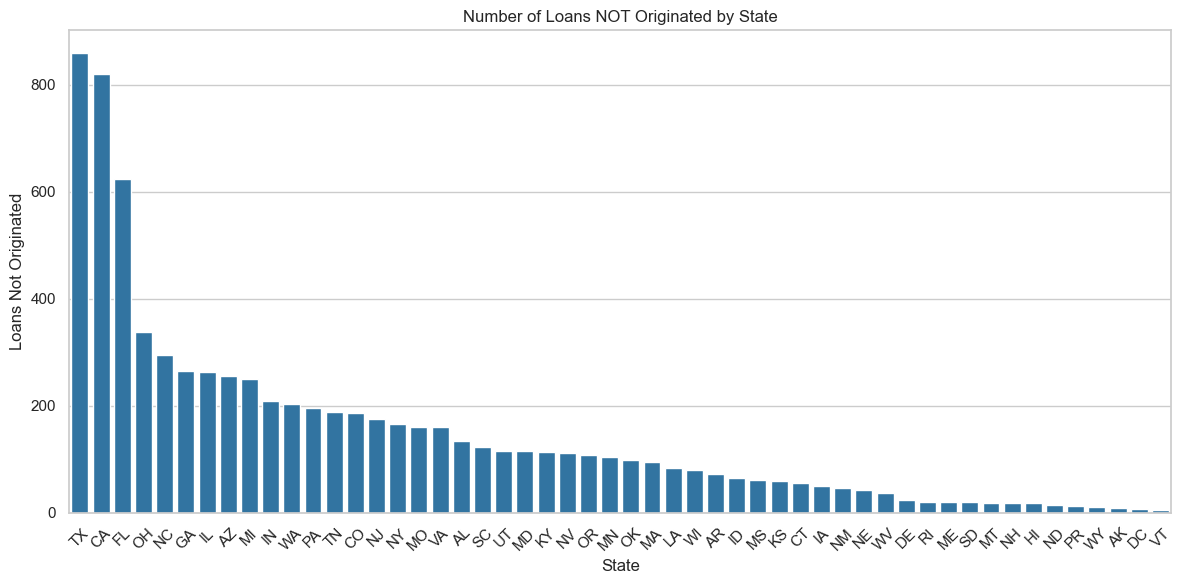

In [19]:
# Loans NOT Originated by State
# ------------------------------------

not_originated = hmda_sample[hmda_sample['action_taken'] != 1]

state_counts_not_originated = (
    not_originated['state_code']
    .value_counts()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12,6))
sns.barplot(
    x=state_counts_not_originated.index,
    y=state_counts_not_originated.values,
    color='#1f77b4'  # BLUE
)
plt.title('Number of Loans NOT Originated by State')
plt.xlabel('State')
plt.ylabel('Loans Not Originated')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


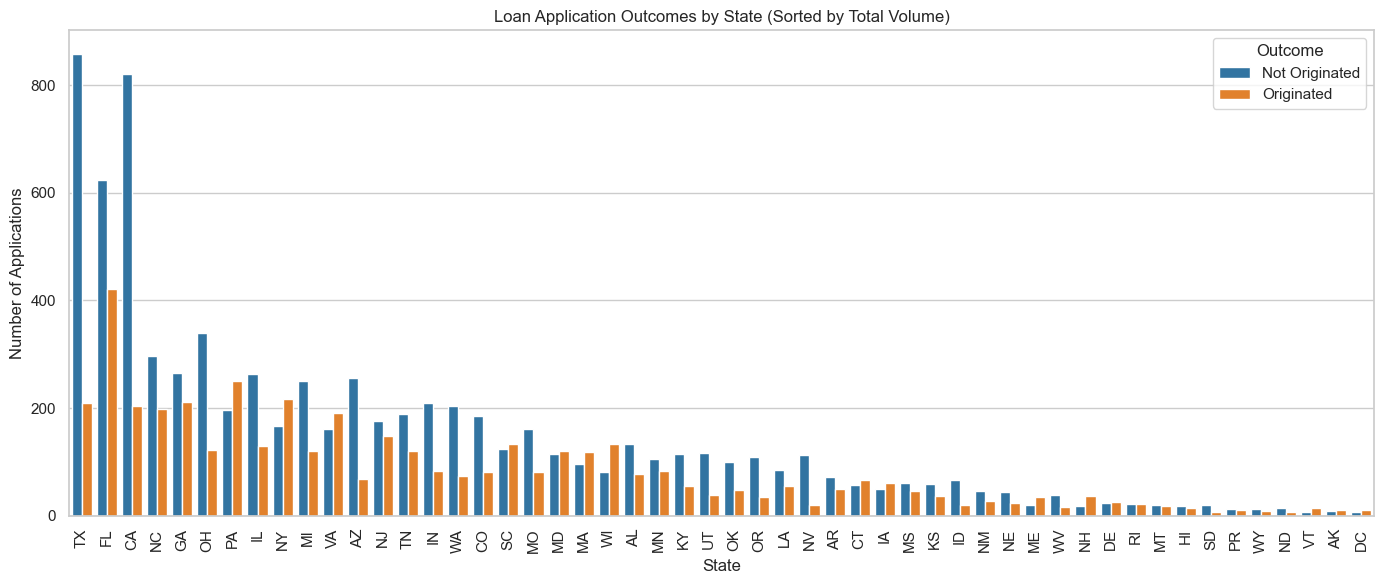

In [20]:
# compare State × Loan Outcome (Sorted by Volume)
# ---------------------------------------

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create binary outcome column
hmda_sample['loan_outcome'] = hmda_sample['action_taken'].apply(
    lambda x: "Originated" if x == 1 else "Not Originated"
)

# 2. Group by state and outcome
state_outcome_counts = (
    hmda_sample.groupby(['state_code', 'loan_outcome'])
    .size()
    .reset_index(name='count')
)

# 3. Add total applications per state
state_totals = (
    state_outcome_counts.groupby('state_code')['count'].sum()
    .reset_index(name='total_apps')
)

# Merge totals back into the long table
state_outcome_counts = state_outcome_counts.merge(state_totals, on='state_code')

# 4. Sort by total applications (descending)
state_outcome_counts = state_outcome_counts.sort_values('total_apps', ascending=False)

# 5. Pivot table (optional)
state_outcome_pivot = (
    state_outcome_counts.pivot(index='state_code',
                               columns='loan_outcome',
                               values='count')
    .fillna(0)
    .astype(int)
    .loc[state_outcome_counts['state_code'].unique()]
)

# ----- CUSTOM COLORS -----
custom_colors = {
    "Not Originated": "#1f77b4",  # BLUE
    "Originated": "#ff7f0e"       # ORANGE
}

# 6. Visualization — 2 bars per state
plt.figure(figsize=(14,6))

sns.barplot(
    data=state_outcome_counts,
    x='state_code',
    y='count',
    hue='loan_outcome',
    order=state_outcome_counts['state_code'].unique(),
    palette=custom_colors  
)

plt.xticks(rotation=90)
plt.title("Loan Application Outcomes by State (Sorted by Total Volume)")
plt.xlabel("State")
plt.ylabel("Number of Applications")
plt.legend(title="Outcome")
plt.tight_layout()
plt.show()


## Distribution Plots (loan amount, applicant income, interest rate)

In [21]:
# loan amount - Check the column type and raw values 

print(hmda_sample['loan_amount'].dtype)
print(hmda_sample['loan_amount'].head(5))
print("Min:", hmda_sample['loan_amount'].min())
print("Max:", hmda_sample['loan_amount'].max())
print("Mean:", hmda_sample['loan_amount'].mean())
print("Median:", hmda_sample['loan_amount'].median())


int64
0    325000
1    325000
2    345000
3    435000
4    415000
Name: loan_amount, dtype: int64
Min: 5000
Max: 45895000
Mean: 397442.1508240386
Median: 305000.0


Top 10 loan amounts: [45895000 31505000 27955000 12835000 10255000 10005000 10005000  9505000
  9155000  7125000]
Bottom 10 loan amounts: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
Median: 305000.0 Mean: 397442.1508240386


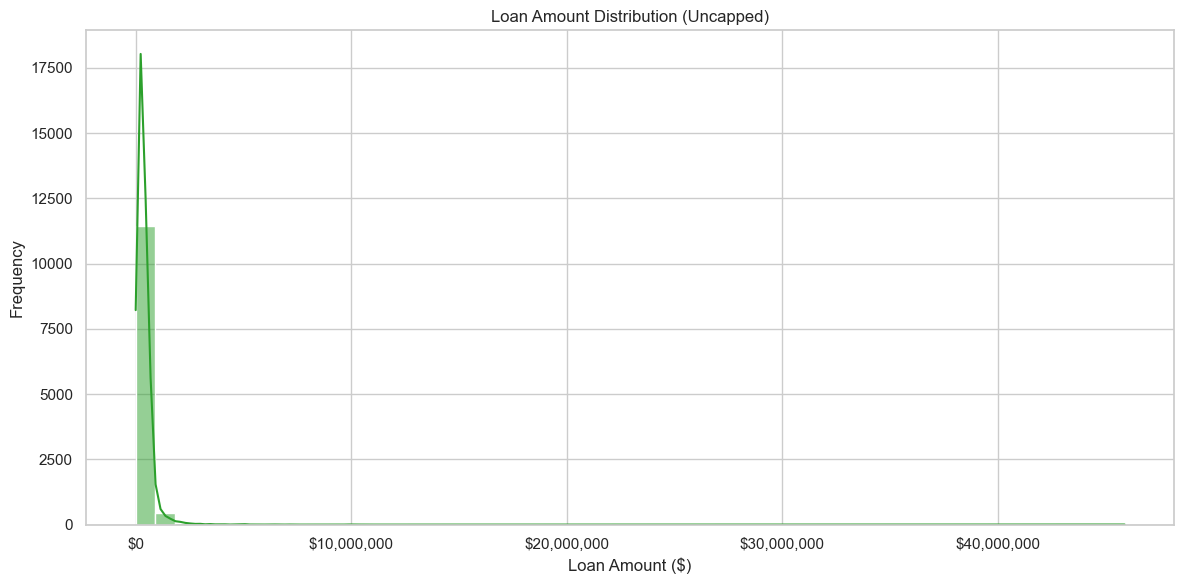

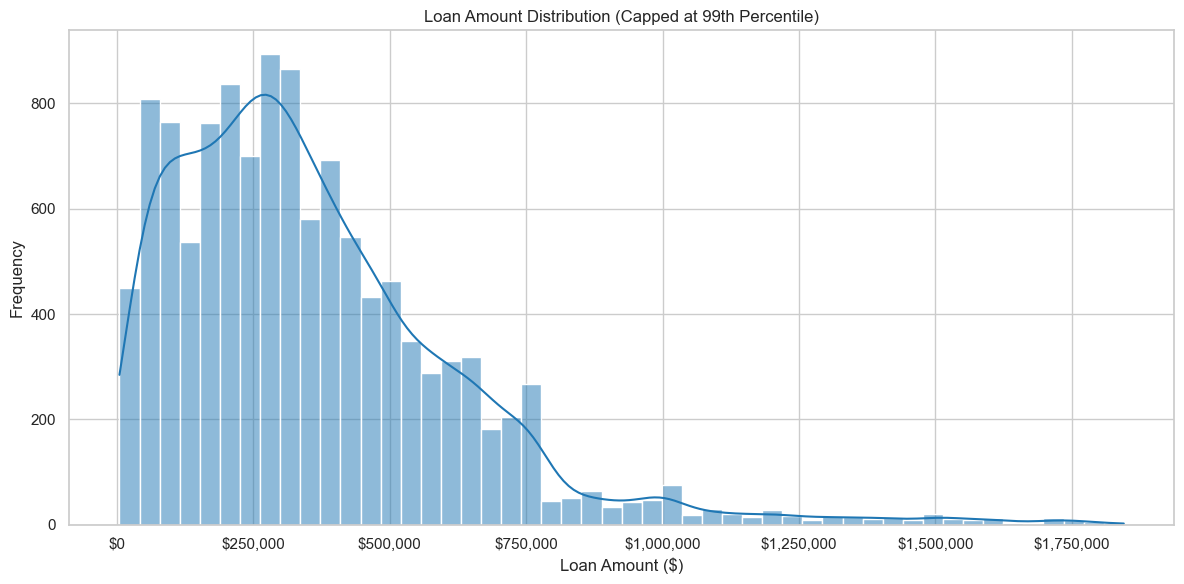

In [22]:
# Loan Amount Distribution Analysis (Capped vs. Uncapped)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# 1️⃣ Clean and inspect raw values
loan_amt_clean = hmda_sample['loan_amount'].dropna()
print("Top 10 loan amounts:", loan_amt_clean.sort_values(ascending=False).head(10).values)
print("Bottom 10 loan amounts:", loan_amt_clean.sort_values().head(10).values)
print("Median:", loan_amt_clean.median(), "Mean:", loan_amt_clean.mean())

# 2️⃣ Plot UNCAPPED distribution
plt.figure(figsize=(12,6))
sns.histplot(loan_amt_clean, bins=50, kde=True, color="#2ca02c")
plt.title("Loan Amount Distribution (Uncapped)")
plt.xlabel("Loan Amount ($)")
plt.ylabel("Frequency")
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.show()

# 3️⃣ Cap outliers at 99th percentile for comparison
cap = loan_amt_clean.quantile(0.99)
loan_amt_capped = loan_amt_clean[loan_amt_clean <= cap]

# 4️⃣ Plot CAPPED distribution
plt.figure(figsize=(12,6))
sns.histplot(loan_amt_capped, bins=50, kde=True, color="#1f77b4")
plt.title("Loan Amount Distribution (Capped at 99th Percentile)")
plt.xlabel("Loan Amount ($)")
plt.ylabel("Frequency")
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.show()


Interest Rate Summary:
Min: 0.00%
Max: 14.84%
Mean: 6.37%
Median: 6.38%
Top 10 interest rates: [14.84 13.34 13.34 13.29 13.09 13.04 12.99 12.99 12.99 12.98]
Bottom 10 interest rates: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


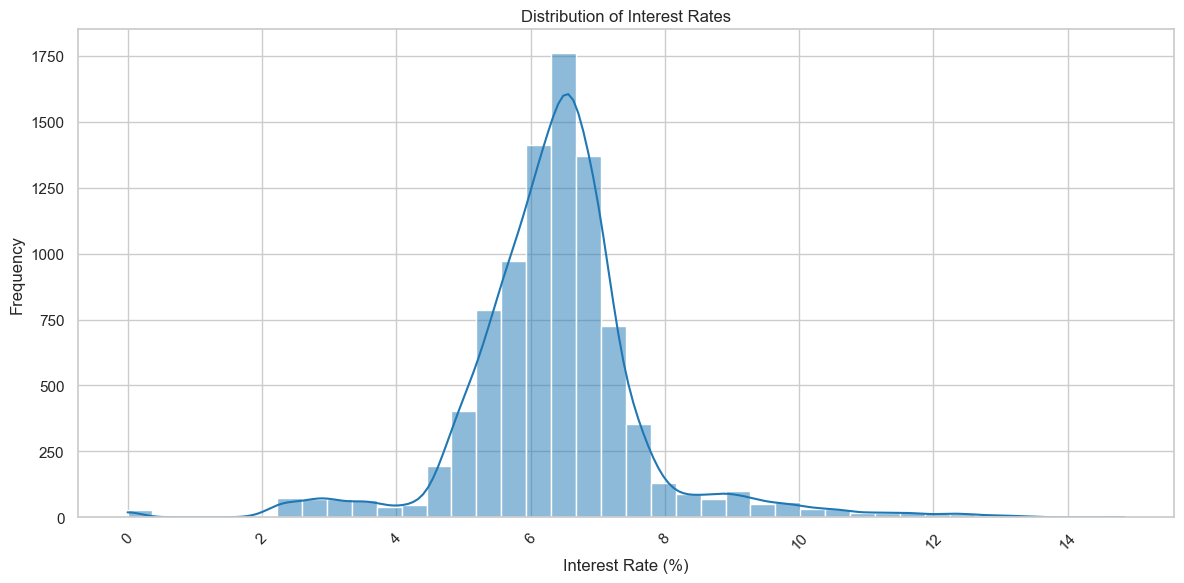


Counts per bin:
       Bin  Count
0     0-0%     27
1     0-0%      0
2     0-1%      0
3     1-1%      0
4     1-1%      0
5     1-2%      5
6     2-2%     72
7     2-2%     70
8     2-3%     68
9     3-3%     66
10    3-4%     38
11    4-4%     47
12    4-4%    193
13    4-5%    403
14    5-5%    787
15    5-5%    974
16    5-6%   1411
17    6-6%   1763
18    6-7%   1371
19    7-7%    726
20    7-7%    352
21    7-8%    129
22    8-8%     87
23    8-8%     70
24    8-9%     99
25    9-9%     51
26   9-10%     57
27  10-10%     30
28  10-10%     33
29  10-11%     15
30  11-11%     15
31  11-11%     20
32  11-12%     12
33  12-12%     14
34  12-12%      4
35  12-13%      8
36  13-13%      0
37  13-14%      0
38  14-14%      0
39  14-14%      1


In [23]:
# interest rate distribution plot (univariate analysis)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Clean interest rate column
interest_clean = hmda_sample['interest_rate'].dropna()

# Print summary statistics
print("Interest Rate Summary:")
print(f"Min: {interest_clean.min():.2f}%")
print(f"Max: {interest_clean.max():.2f}%")
print(f"Mean: {interest_clean.mean():.2f}%")
print(f"Median: {interest_clean.median():.2f}%")
print(f"Top 10 interest rates: {interest_clean.sort_values(ascending=False).head(10).values}")
print(f"Bottom 10 interest rates: {interest_clean.sort_values().head(10).values}")

# Histogram plot
plt.figure(figsize=(12,6))
sns.histplot(
    interest_clean,
    bins=40,
    kde=True,
    color="#1f77b4"
)

plt.title("Distribution of Interest Rates")
plt.xlabel("Interest Rate (%)")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: counts per bin
bin_counts, bin_edges = np.histogram(interest_clean, bins=40)
bin_ranges = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}%" for i in range(len(bin_edges)-1)]
bin_summary = pd.DataFrame({'Bin': bin_ranges, 'Count': bin_counts})
print("\nCounts per bin:")
print(bin_summary)


Age Value Counts:
applicant_age
35-44    1968
25-34    1512
45-54    1499
55-64    1210
65-74     810
>74       312
<25       180
Name: count, dtype: int64


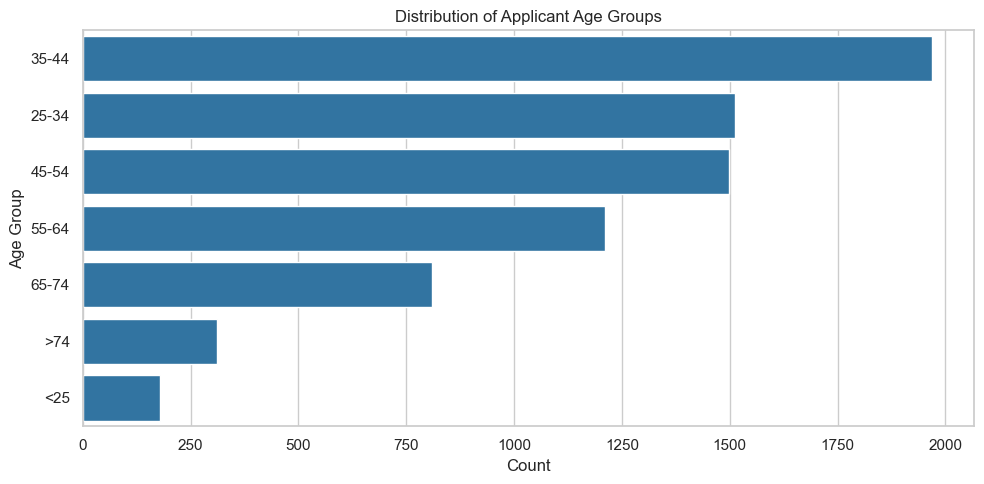

In [24]:
# 4.2.x Applicant Age — Summary + Distribution
# ---------------------------------------------

# Replace HMDA special values and keep useful ones
age_clean = (
    hmda_sample['applicant_age']
    .replace(["9999", "8888", "Exempt", "NA"], np.nan)
    .dropna()
)

print("Age Value Counts:")
print(age_clean.value_counts())

# Bar chart (because age is categorical)
plt.figure(figsize=(10,5))
sns.countplot(
    y=age_clean,
    order=age_clean.value_counts().index,
    color="#1f77b4"
)

plt.title("Distribution of Applicant Age Groups")
plt.xlabel("Count")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()


DTI Summary:
Min: 25.0 %
Max: 55.0 %
Mean: 35.38 %
Median: 33.0 %


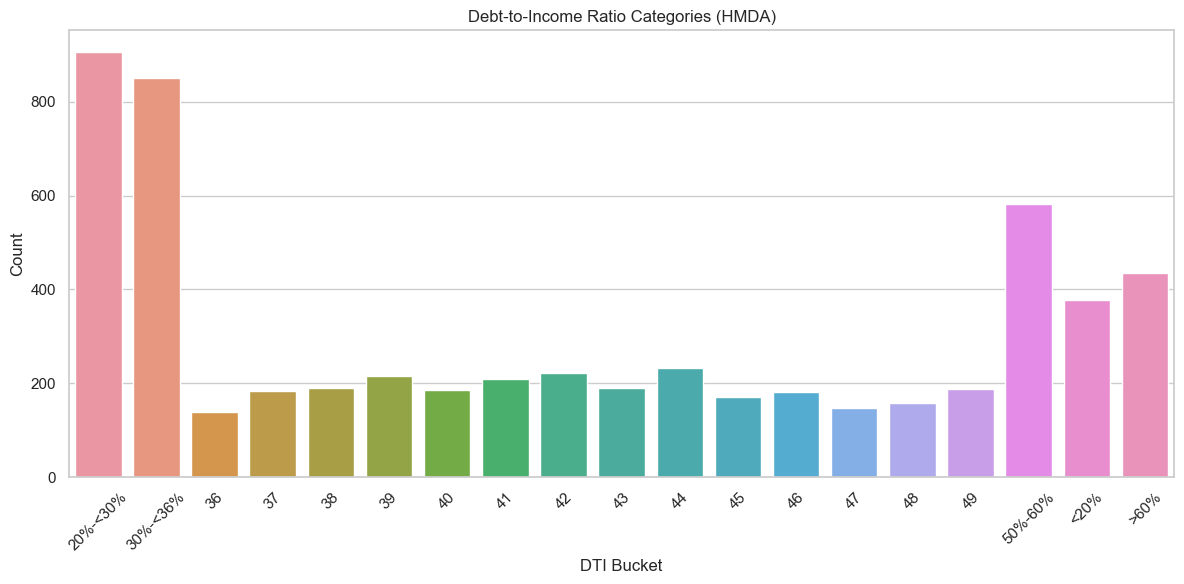

In [25]:
# Debt-to-Income Ratio (DTI) — Summary + Distribution
import re
import numpy as np
import matplotlib.pyplot as plt

# Function to parse DTI bucket strings
def parse_dti_bucket(value):
    if isinstance(value, str):
        # Clean common non-numeric values
        if value in ["NA", "Exempt"]:
            return np.nan
        
        # Case 1: Single value like "36%"
        if re.match(r"^\d+%$", value):
            return float(value.replace("%", ""))

        # Case 2: Ranges like "30%-<36%"
        match = re.match(r"(\d+)%-*<*(\d+)%", value)
        if match:
            low, high = match.groups()
            low, high = float(low), float(high)
            return (low + high) / 2  # midpoint

    return np.nan

# Apply parsing function to DTI column
dti_numeric = hmda_sample['debt_to_income_ratio'].apply(parse_dti_bucket).dropna()

# Summary statistics
print("DTI Summary:")
print("Min:", dti_numeric.min(), "%")
print("Max:", dti_numeric.max(), "%")
print("Mean:", round(dti_numeric.mean(),2), "%")
print("Median:", round(dti_numeric.median(),2), "%")


# Plot DTI distribution
dti_raw = hmda_sample['debt_to_income_ratio']
category_counts = dti_raw.value_counts().sort_index()

plt.figure(figsize=(12,6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xticks(rotation=45)
plt.title("Debt-to-Income Ratio Categories (HMDA)")
plt.ylabel("Count")
plt.xlabel("DTI Bucket")
plt.tight_layout()
plt.show()




In [26]:
# Bivariate Analysis

# These explore relationships and patterns between features. This helps with feature engineering and spotting interactions:


# b. Applicant income vs interest rate

# This shows if lower/higher income applicants are paying higher interest rates.

# Can help identify patterns like risk-based pricing or lending bias.

# c. Loan amount vs interest rate

# Helps see if larger loans tend to have lower or higher rates.

# Could inform feature engineering (e.g., rate brackets).

# d. Applicant age vs state/county

# Useful for demographic analysis or derived features (like age brackets).

# Could reveal trends like certain states having younger or older borrowers.

# Can be done later at the county level to see volume + age patterns.


# a debt to income level compared to another feature as well


Income Summary:
Min: -997.0
Max: 15000.0
Mean: 207.176568573015
Median: 125.0

Loan Amount Summary:
Min: 5000.0
Max: 27955000.0
Mean: 396195.1693503609
Median: 285000.0


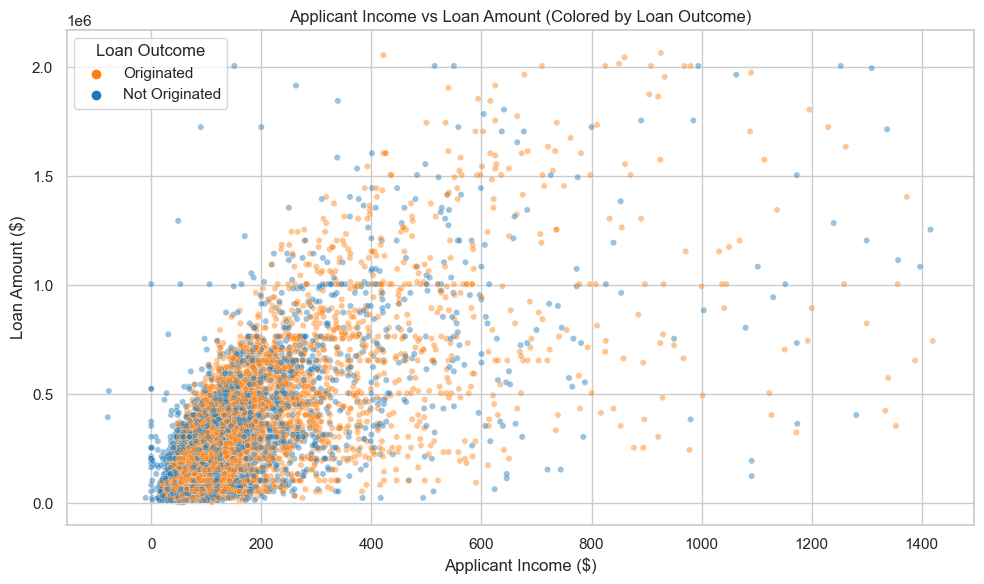

In [27]:
# Applicant income vs loan amount (bivariate analysis)


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# 1. Clean income + loan amount
# ================================
df_clean = hmda_sample[['income', 'loan_amount', 'loan_outcome']].copy()

# Replace NA/exempt & convert to float
df_clean = df_clean.replace(["NA", "Exempt"], np.nan)
df_clean['income'] = df_clean['income'].astype(float)
df_clean['loan_amount'] = df_clean['loan_amount'].astype(float)

# Drop missing rows
df_clean = df_clean.dropna()

# ================================
# 2. Cap outliers at 99th percentile
# ================================
inc_cap = df_clean['income'].quantile(0.99)
loan_cap = df_clean['loan_amount'].quantile(0.99)

df_plot = df_clean[
    (df_clean['income'] <= inc_cap) &
    (df_clean['loan_amount'] <= loan_cap)
]

# ================================
# 3. Print summaries
# ================================
print("Income Summary:")
print("Min:", df_clean['income'].min())
print("Max:", df_clean['income'].max())
print("Mean:", df_clean['income'].mean())
print("Median:", df_clean['income'].median())

print("\nLoan Amount Summary:")
print("Min:", df_clean['loan_amount'].min())
print("Max:", df_clean['loan_amount'].max())
print("Mean:", df_clean['loan_amount'].mean())
print("Median:", df_clean['loan_amount'].median())

# ================================
# 4. Scatterplot with color by loan outcome (strings)
# ================================
plt.figure(figsize=(10,6))

sns.scatterplot(
    data=df_plot,
    x='income',
    y='loan_amount',
    hue='loan_outcome',  # column contains "Originated" / "Not Originated"
    palette={"Not Originated": "#1f77b4", "Originated": "#ff7f0e"},  # keys match string values
    alpha=0.45,
    s=20
)

plt.title("Applicant Income vs Loan Amount (Colored by Loan Outcome)")
plt.xlabel("Applicant Income ($)")
plt.ylabel("Loan Amount ($)")
plt.legend(title="Loan Outcome")
plt.tight_layout()
plt.show()



# 5.0 Feature Engineering

In [28]:
# Load County FIPS Data
import pandas as pd

county_df = pd.read_csv(
    "national_county.txt",
    header=None,
    names=["state", "state_fips", "county_fips", "county_name", "class_code"]
)

county_df.head()


,state,state_fips,county_fips,county_name,class_code
0,AL,1,1,Autauga County,H1
1,AL,1,3,Baldwin County,H1
2,AL,1,5,Barbour County,H1
3,AL,1,7,Bibb County,H1
4,AL,1,9,Blount County,H1


In [31]:
# # Load full data set for Texas Only for Further Analysis (8 mins to run)
# import pandas as pd

# # Load the full dataset (CSV or Parquet)
# hmda_full = pd.read_csv("2024_public_lar_csv.csv")  # full file path

# # Optional: filter for Texas only
# tx_loans = hmda_full[hmda_full['state_code'] == 'TX'].copy()

# print(tx_loans.shape)


## logic needs to be fixed for counties

In [56]:
# Filter to Texas counties only
tx_counties = county_df[county_df['state'] == "TX"].copy()

# County FIPS must be 3-digit zero-padded strings
tx_counties['county_fips'] = tx_counties['county_fips'].astype(str).str.zfill(3)

tx_counties.head()


,state,state_fips,county_fips,county_name,class_code
2523,TX,48,001,Anderson County,H1
2524,TX,48,003,Andrews County,H1
2525,TX,48,005,Angelina County,H1
2526,TX,48,007,Aransas County,H1
2527,TX,48,009,Archer County,H1


In [41]:
# Prepare the Census county table

# Load the national county file if not done yet
county_df = pd.read_csv(
    "national_county.txt",
    header=None,
    names=["state", "state_fips", "county_fips", "county_name", "class_code"]
)

# Filter to Texas (state_fips = 48)
county_tx = county_df[county_df["state_fips"] == 48].copy()

# Make sure county_fips is string padded
county_tx["county_fips"] = county_tx["county_fips"].astype(str).str.zfill(3)


## Visualize Application Volume by County

## Look for Outliers & Anomalies

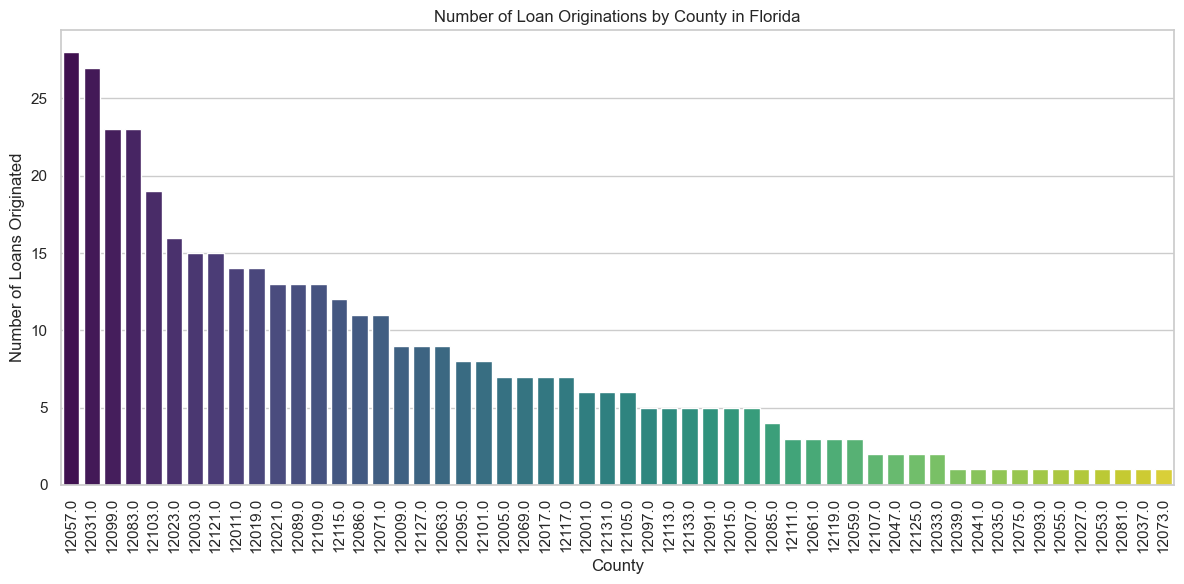

In [47]:
# Filter only loans originated in Florida by county
fl_loans = originated[originated['state_code'] == 'FL']

# Count loans per county in FL
fl_county_counts = fl_loans['county_code'].value_counts()

# Convert to DataFrame for plotting
fl_county_df = fl_county_counts.reset_index()
fl_county_df.columns = ['County', 'Loans Originated']

# Sort by number of loans
fl_county_df = fl_county_df.sort_values(by='Loans Originated', ascending=False)  # descending order

# Plot with explicit order
plt.figure(figsize=(12,6))
sns.barplot(
    x='County',
    y='Loans Originated',
    data=fl_county_df,
    palette="viridis",
    order=fl_county_df['County']  
)
plt.xticks(rotation=90)
plt.title('Number of Loan Originations by County in Florida')
plt.xlabel('County')
plt.ylabel('Number of Loans Originated')
plt.tight_layout()
plt.show()

In [48]:
# Create a dictionary: county_code (zero-padded) -> county name
fl_county_mapping = {
    '001': 'Alachua County',
    '003': 'Baker County',
    '005': 'Bay County',
    '007': 'Bradford County',
    '009': 'Brevard County',
    '011': 'Broward County',
    '013': 'Calhoun County',
    '015': 'Charlotte County',
    '017': 'Citrus County',
    '019': 'Clay County',
    '021': 'Collier County',
    '023': 'Columbia County',
    '027': 'DeSoto County',
    '029': 'Dixie County',
    '031': 'Duval County',
    '033': 'Escambia County',
    '035': 'Flagler County',
    '037': 'Franklin County',
    '039': 'Gadsden County',
    '041': 'Gilchrist County',
    '043': 'Glades County',
    '045': 'Gulf County',
    '047': 'Hamilton County',
    '049': 'Hardee County',
    '051': 'Hendry County',
    '053': 'Hernando County',
    '055': 'Highlands County',
    '057': 'Hillsborough County',
    '059': 'Holmes County',
    '061': 'Indian River County',
    '063': 'Jackson County',
    '065': 'Jefferson County',
    '067': 'Lafayette County',
    '069': 'Lake County',
    '071': 'Lee County',
    '073': 'Leon County',
    '075': 'Levy County',
    '077': 'Liberty County',
    '079': 'Madison County',
    '081': 'Manatee County',
    '083': 'Marion County',
    '085': 'Martin County',
    '086': 'Miami-Dade County',
    '087': 'Monroe County',
    '089': 'Nassau County',
    '091': 'Okaloosa County',
    '093': 'Okeechobee County',
    '095': 'Orange County',
    '097': 'Osceola County',
    '099': 'Palm Beach County',
    '101': 'Pasco County',
    '103': 'Pinellas County',
    '105': 'Polk County',
    '107': 'Putnam County',
    '109': 'St. Johns County',
    '111': 'St. Lucie County',
    '113': 'Santa Rosa County',
    '115': 'Sarasota County',
    '117': 'Seminole County',
    '119': 'Sumter County',
    '121': 'Suwannee County',
    '123': 'Taylor County',
    '125': 'Union County',
    '127': 'Volusia County',
    '129': 'Wakulla County',
    '131': 'Walton County',
    '133': 'Washington County'
}

# Extract last 3 digits and zero-pad
fl_loans['county_code_3'] = fl_loans['county_code'].apply(lambda x: str(int(x))[-3:].zfill(3))

# Map to county names
fl_loans['county_name'] = fl_loans['county_code_3'].map(fl_county_mapping)

# Check result
fl_loans[['county_code', 'county_code_3', 'county_name']].head(10)




C:\Users\jtqua\AppData\Local\Temp\ipykernel_7804\2833788167.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fl_loans['county_code_3'] = fl_loans['county_code'].apply(lambda x: str(int(x))[-3:].zfill(3))
C:\Users\jtqua\AppData\Local\Temp\ipykernel_7804\2833788167.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fl_loans['county_name'] = fl_loans['county_code_3'].map(fl_county_mapping)


,county_code,county_code_3,county_name
2158,12019.0,019,Clay County
2159,12063.0,063,Jackson County
2161,12115.0,115,Sarasota County
2167,12086.0,086,Miami-Dade County
2168,12019.0,019,Clay County
2170,12105.0,105,Polk County
2172,12091.0,091,Okaloosa County
2174,12105.0,105,Polk County
2177,12003.0,003,Baker County
2178,12015.0,015,Charlotte County


In [49]:
# convert county codes to names using a predefined mapping
county_counts = fl_loans['county_name'].value_counts().sort_values(ascending=False)

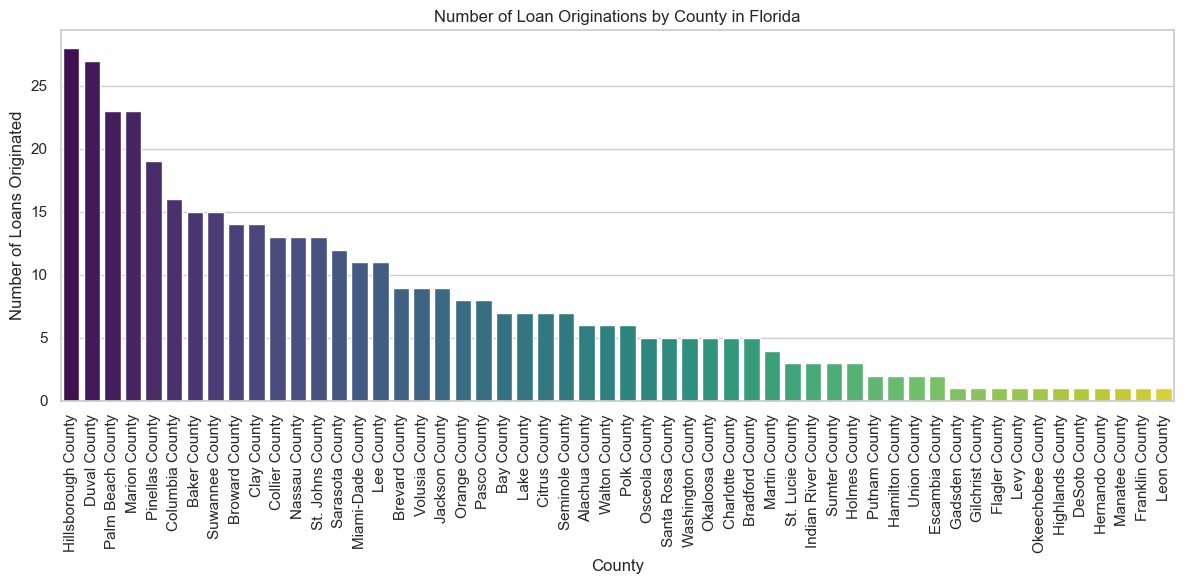

In [50]:
# Plot total loans originated by county in Florida  
plt.figure(figsize=(12,6))
sns.barplot(x=county_counts.index, y=county_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.title('Number of Loan Originations by County in Florida')
plt.xlabel('County')
plt.ylabel('Number of Loans Originated')
plt.tight_layout()
plt.show()

In [62]:
# Create binary approved column target
hmda_sample["approved"] = hmda_sample["action_taken"].apply(
    lambda x: 1 if x == 1 else 0
)


In [63]:
# Map applicant age groups to numeric codes
age_map = {
    '<25': 1, '25-34': 2, '35-44': 3, '45-54': 4,
    '55-64': 5, '65-74': 6, '>74': 7
}
hmda_sample["age_clean"] = hmda_sample["applicant_age"].map(age_map)


In [64]:
# Map debt-to-income ratio buckets to numeric midpoints
dti_map = {
    '<20%': 20, '20%-<30%': 25, '30%-<36%': 33,
    '36': 36, '37': 37, '39': 39, '42': 42, '47': 47, '49': 49,
    '50%-60%': 55, '>60%': 65
}
hmda_sample["dti_clean"] = hmda_sample["debt_to_income_ratio"].map(dti_map)


In [65]:
# Convert income, loan amount, and property value to numeric
for col in ["loan_amount", "income", "property_value"]:
    hmda_sample[col] = pd.to_numeric(hmda_sample[col], errors="coerce")


In [66]:
# Drop rows with missing target or key features
data = hmda_sample.dropna(subset=["approved", "loan_amount", "income"])


In [67]:
# Quick check of cleaned features
print(data[['applicant_age', 'debt_to_income_ratio']].head(20))
print(data[['applicant_age', 'debt_to_income_ratio']].info())


   applicant_age debt_to_income_ratio
0          25-34             30%-<36%
2          55-64             20%-<30%
3          45-54                   36
5          35-44             20%-<30%
7          25-34                   49
8          25-34             30%-<36%
9          25-34                   37
12         65-74                   36
13         45-54                 <20%
14         35-44                   39
15         25-34                   45
16         35-44              50%-60%
17           >74                   37
18         25-34                   37
20         45-54                   49
23         35-44             30%-<36%
26         35-44                  NaN
30         55-64                  NaN
31         65-74                  NaN
32         35-44              50%-60%
<class 'pandas.core.frame.DataFrame'>
Index: 7204 entries, 0 to 12014
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 


In [68]:
# Convert debt-to-income ratio strings to numeric midpoints

import numpy as np

def dti_to_numeric(val):
    if pd.isna(val):
        return np.nan
    val = str(val)
    if '-' in val:
        # e.g., "30%-<36%" -> take midpoint
        numbers = [int(s.replace('%','')) for s in val.replace('<','').split('-') if s.replace('%','').isdigit()]
        if numbers:
            return np.mean(numbers)
        else:
            return np.nan
    elif val.replace('%','').isdigit():
        return int(val.replace('%',''))
    else:
        return np.nan

data['dti_numeric'] = data['debt_to_income_ratio'].apply(dti_to_numeric)
print(data['dti_numeric'].describe())


count    4895.000000
mean       39.142594
std         9.290486
min        25.000000
25%        33.000000
50%        39.000000
75%        46.000000
max        55.000000
Name: dti_numeric, dtype: float64


C:\Users\jtqua\AppData\Local\Temp\ipykernel_7804\3578154337.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dti_numeric'] = data['debt_to_income_ratio'].apply(dti_to_numeric)


In [69]:
# Remove the problematic column
if 'dti_numeric' in data.columns:
    data = data.drop(columns=['dti_numeric'])

# Make sure the pipeline uses dti_clean
numeric = ["loan_amount", "income", "property_value", "age_clean", "dti_clean"]


# Model Development & Training

## Train/Test Split

In [70]:
# Split data into features and target
features = [
    "loan_amount", "income", "property_value",
    "age_clean", "dti_clean",
    "loan_type", "loan_purpose", "occupancy_type"
]

X = data[features]
y = data["approved"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)



## Baseline Model

In [71]:
# Baseline Dummy Classifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
baseline_acc = dummy.score(X_test, y_test)
print("Baseline accuracy:", baseline_acc)
print("This model always predicts the majority class (‘not originated’). It gives a minimum benchmark for judging whether my ML models add value.")

Baseline accuracy: 0.5802332037756802
This model always predicts the majority class (‘not originated’). It gives a minimum benchmark for judging whether my ML models add value.


## Logistic Regression

In [72]:
# Logistic Regression with Preprocessing Pipeline


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression


# Define preprocessing for numeric and categorical features
numeric = ["loan_amount", "income", "property_value", "dti_clean"]
categorical = ["age_clean", "loan_type", "loan_purpose", "occupancy_type"]

# Preprocessing pipelines
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")) # median imputation for numeric
])

# Categorical pipeline
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")), # mode imputation for categorical
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine preprocessing steps
preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric),
    ("cat", categorical_transformer, categorical)
])
 # Create full pipeline with logistic regression
log_reg = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=200)) # increased max_iter to ensure convergence
])

# Train and evaluate logistic regression model
log_reg.fit(X_train, y_train)
lr_acc = log_reg.score(X_test, y_test)
print("Logistic Regression accuracy:", lr_acc)


Logistic Regression accuracy: 0.5907828983897835


In [73]:
# Hyperparameter Tuning for Logistic Regression
param_grid_lr = {
    "model__C": [0.1, 1, 10] # regularization strength 0.1, 1, 10 are common starter values
}



In [74]:
# Perform grid search

from sklearn.model_selection import GridSearchCV

search_lr = GridSearchCV(log_reg, param_grid_lr, cv=3)
search_lr.fit(X_train, y_train)
search_lr.best_params_


{'model__C': 0.1}

## 8.2 Random Forest

In [75]:
# Random Forest Classifier with Preprocessing Pipeline

rf = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(n_estimators=200)) # increased n_estimators for better performance
])

rf.fit(X_train, y_train)
rf_acc = rf.score(X_test, y_test)
print("Random Forest accuracy:", rf_acc)


Random Forest accuracy: 0.8228761799000556


In [76]:
# Hyperparameter Tuning with Grid Search

from sklearn.model_selection import GridSearchCV

param_grid = {
    "model__n_estimators": [100, 200, 300], # number of trees
    "model__max_depth": [None, 10, 20], # maximum depth of each tree
    "model__max_features": ["sqrt", "log2"] # number of features to consider at each split
}
# Define parameter grid for tuning
search = GridSearchCV(
    rf, # the random forest pipeline
    param_grid, # parameter grid defined above
    cv=3, # 3-fold cross-validation
    n_jobs=-1, # use all CPU cores
    scoring="accuracy" # optimize for accuracy
)
search.fit(X_train, y_train) # perform the grid search

search.best_params_, search.best_score_ # show best params and CV score


({'model__max_depth': 10,
  'model__max_features': 'log2',
  'model__n_estimators': 100},
 0.8376827688321303)

## Gradient Boosting Classifier

In [77]:
# Gradient Boosting Classifier with Preprocessing Pipeline
# default learning_rate, default number of estimators (100), default max depth (3)

from sklearn.ensemble import GradientBoostingClassifier

gb = Pipeline([
    ("preprocess", preprocess),
    ("model", GradientBoostingClassifier())
])

gb.fit(X_train, y_train)
gb_acc = gb.score(X_test, y_test)
print("Gradient Boosting accuracy:", gb_acc)


Gradient Boosting accuracy: 0.8334258745141588


# 9.0 Model Comparison


In [79]:
# Model Evaluation and Comparison

import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# Dictionary to store results
results = {}

# List of models
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,       # use tuned rf if desired: search.best_estimator_
    "Gradient Boosting": gb
}

# Optional: If using tuned RF from GridSearchCV
# rf_best = search.best_estimator_
# models["Random Forest"] = rf_best

# Evaluate each model
for name, model in models.items():
    start_time = time.time()  # track training time
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    
    # For AUC, need probabilities
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        auc = None
    
    # Rough interpretability estimate
    if name == "Logistic Regression":
        interpretability = "High (coefficients understandable)"
    elif name == "Random Forest":
        interpretability = "Medium (feature importance available)"
    else:
        interpretability = "Low (ensemble model)"
    
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "AUC": auc,
        "Training Time (s)": round(train_time, 2),
        "Interpretability": interpretability
    }

# Convert to DataFrame for a nice table
results_df = pd.DataFrame(results).T
results_df = results_df[["Accuracy", "Precision", "Recall", "F1", "AUC", "Training Time (s)", "Interpretability"]]
print(results_df)


                     Accuracy Precision    Recall        F1       AUC  \
Logistic Regression  0.590783   0.58642       1.0    0.7393  0.586509   
Random Forest        0.826208  0.822183   0.89378  0.856488   0.87787   
Gradient Boosting    0.833426   0.80709  0.936842  0.867139  0.889672   

                    Training Time (s)                       Interpretability  
Logistic Regression              0.02     High (coefficients understandable)  
Random Forest                    1.48  Medium (feature importance available)  
Gradient Boosting                0.53                   Low (ensemble model)  


<Figure size 1000x600 with 0 Axes>

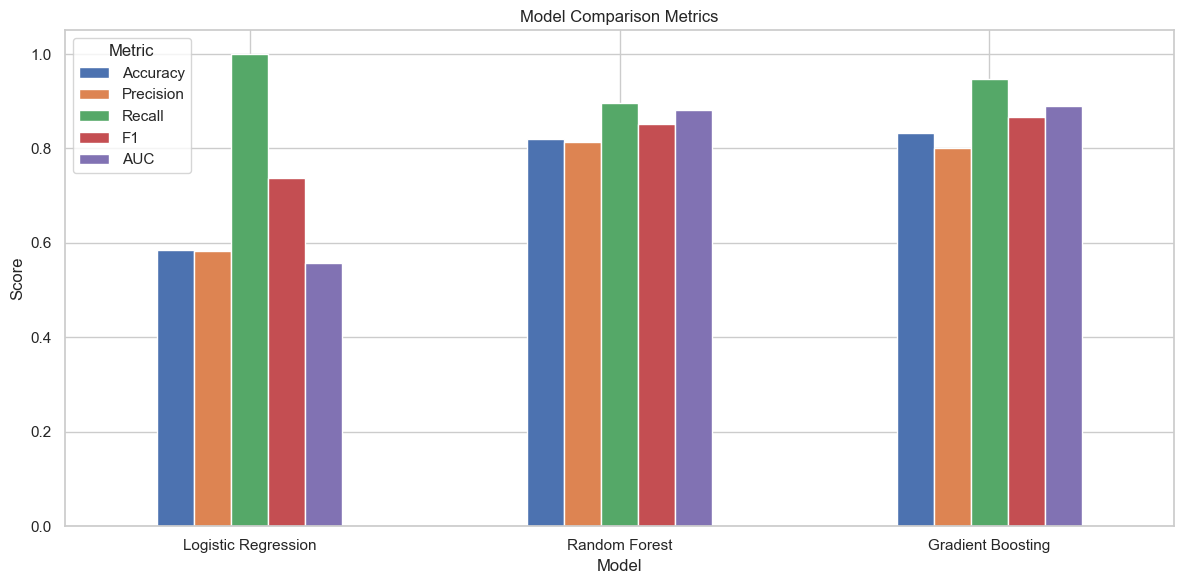

,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Logistic Regression,0.586016,0.583705,1.000000,0.737139,0.557662
Random Forest,0.820200,0.813368,0.895793,0.852593,0.880861
Gradient Boosting,0.832408,0.800971,0.946463,0.867660,0.889413


In [80]:
# Visualize Model Comparison

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Recreate your results_df from the numbers you printed
results_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting"],
    "Accuracy": [0.586016, 0.8202, 0.832408],
    "Precision": [0.583705, 0.813368, 0.800971],
    "Recall": [1.0, 0.895793, 0.946463],
    "F1": [0.737139, 0.852593, 0.86766],
    "AUC": [0.557662, 0.880861, 0.889413]
})

# Set model names as index
results_df = results_df.set_index("Model")

# Plot comparison for selected metrics
metrics = ["Accuracy", "Precision", "Recall", "F1", "AUC"]

plt.figure(figsize=(10,6))
results_df[metrics].plot(kind="bar", figsize=(12,6))

plt.title("Model Comparison Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

results_df


# 10.0 Feature Importance


Top feature importances:
property_value: 0.3803
income: 0.1693
dti_clean: 0.1597
loan_amount: 0.1551
loan_purpose_1.0: 0.0152
age_clean_3.0: 0.0129
loan_purpose_2.0: 0.0118
age_clean_4.0: 0.0100
age_clean_5.0: 0.0084
loan_type_1.0: 0.0081
age_clean_2.0: 0.0078
age_clean_6.0: 0.0077
loan_purpose_4.0: 0.0068
loan_type_3.0: 0.0068
loan_purpose_31.0: 0.0067


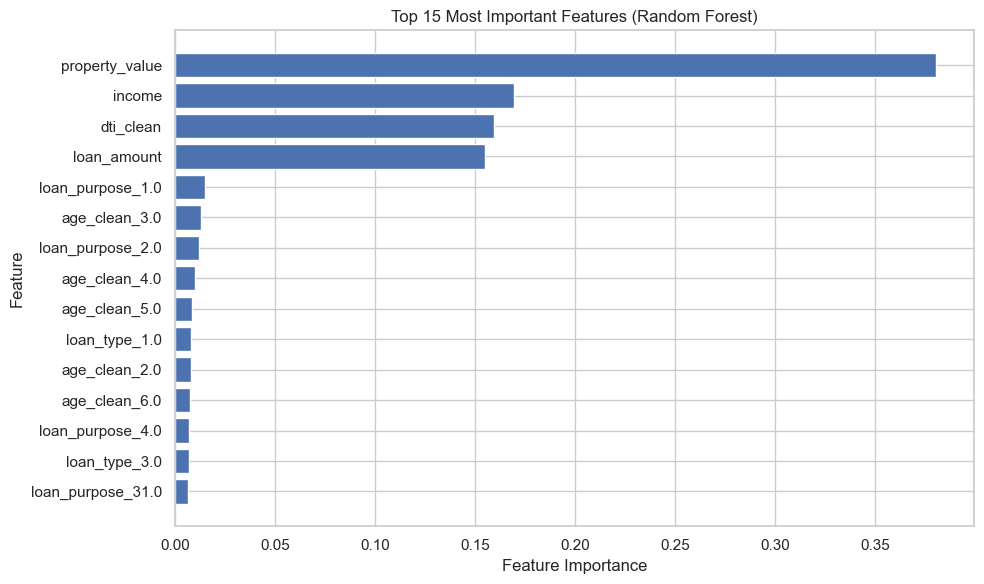

In [82]:
# Feature Importance from Random Forest


import numpy as np
import matplotlib.pyplot as plt

# Fit random forest again but keep access to model directly
rf_model_only = RandomForestClassifier(n_estimators=200)
rf_model_only.fit(
    preprocess.fit_transform(X_train), 
    y_train
)

# Get feature names after preprocessing
feature_names = (
    numeric +
    list(preprocess.named_transformers_['cat']['onehot'].get_feature_names_out(categorical))
)

# Feature importance
importances = rf_model_only.feature_importances_

# Sort top features
indices = np.argsort(importances)[::-1][:15]  # top 15

print("Top feature importances:")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

# --- Bar Chart of Feature Importance ---
plt.figure(figsize=(10, 6))
plt.barh(
    [feature_names[i] for i in indices][::-1],
    [importances[i] for i in indices][::-1]
)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 15 Most Important Features (Random Forest)")
plt.tight_layout()
plt.show()


## 11 Model Evaluation & Diagnostics 

Confusion Matrix:
[[554 202]
 [111 934]]


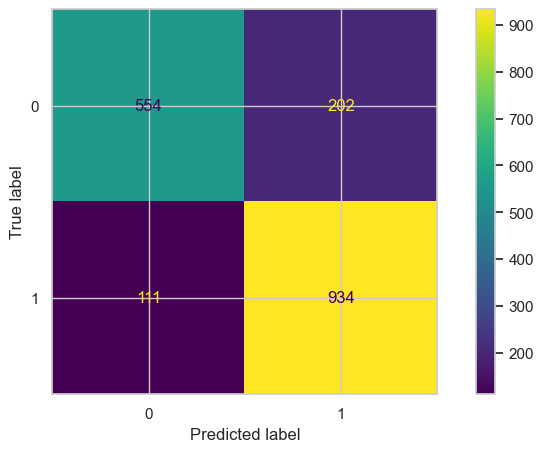

In [83]:
# Confusion Matrix for Random Forest: TP, FP, TN, FN interpretation

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print("Confusion Matrix:")
print(cm)    # [[TN FP]
              #  [FN TP]]   



Confusion Matrix Summary:
True Negatives (TN): 554
False Positives (FP): 202
False Negatives (FN): 111
True Positives (TP): 934
Total samples: 1801
Accuracy check: 0.8262


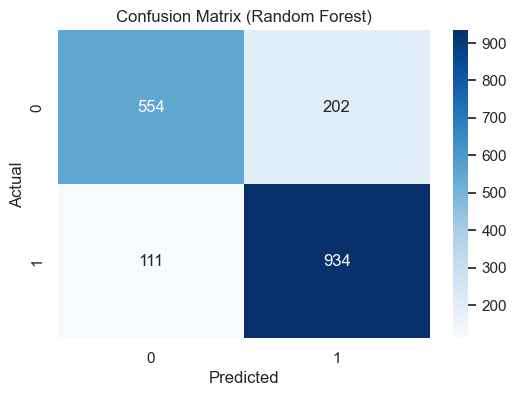

In [84]:
# Detailed Confusion Matrix Analysis

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# --- Printed Summary ---
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix Summary:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"Total samples: {cm.sum()}")
print(f"Accuracy check: {(tp + tn) / cm.sum():.4f}")

# --- Heatmap Visualization ---
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()




In [85]:
# Precision, recall, F1 – to analyze class balance trade-offs
# Classification Report for Random Forest
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.73      0.78       756
           1       0.82      0.89      0.86      1045

    accuracy                           0.83      1801
   macro avg       0.83      0.81      0.82      1801
weighted avg       0.83      0.83      0.82      1801



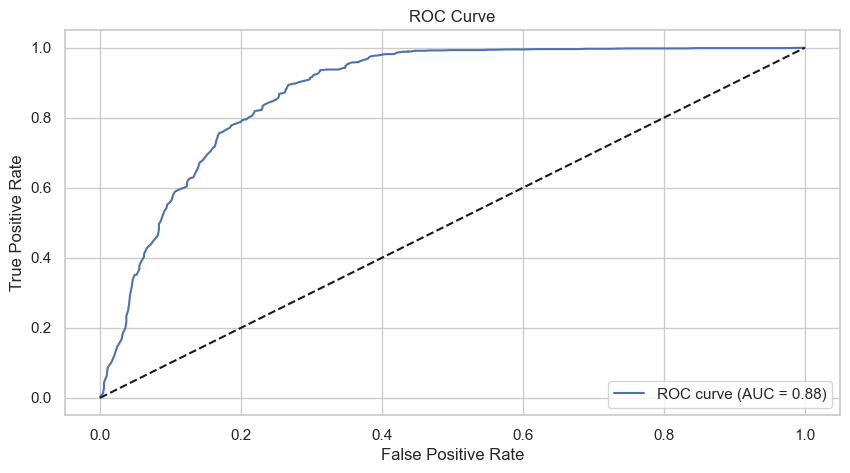

AUC: 0.8778701805017595


In [86]:
# ROC Curve and AUC for Random Forest

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = rf.predict_proba(X_test)[:, 1]  # probability for positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
print("AUC:", roc_auc)  

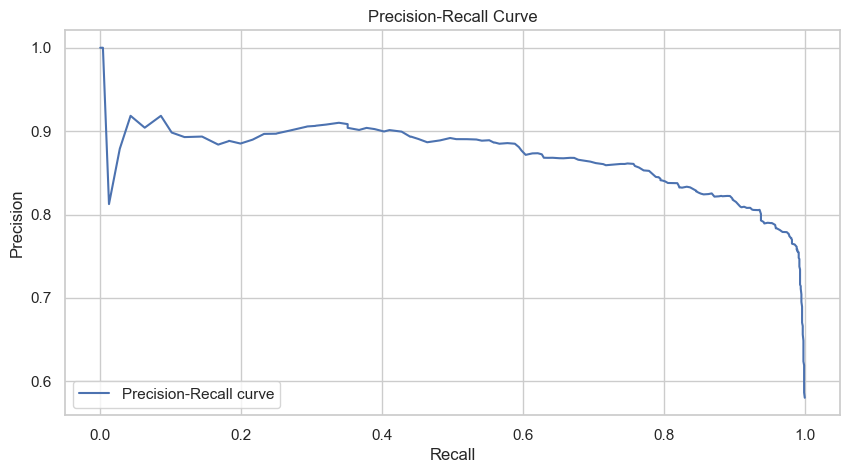

In [87]:

# Precision-Recall Curve for Random Forest
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve') 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")        
plt.show()



# Cross-Validation (with Random Forest)

In [88]:
# Cross-Validation for Random Forest
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Use the same preprocessing pipeline as before
rf_cv = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42))
])

# Perform 5-fold cross-validation
cv_results = cross_validate(
    rf_cv,
    X_train,
    y_train,
    cv=5,
    scoring=["accuracy", "precision", "recall", "f1"],
    return_train_score=True,
    n_jobs=-1
)

# Print mean ± std for each metric
for metric in ["accuracy", "precision", "recall", "f1"]:
    train_mean = np.mean(cv_results[f"train_{metric}"])
    train_std = np.std(cv_results[f"train_{metric}"])
    val_mean = np.mean(cv_results[f"test_{metric}"])
    val_std = np.std(cv_results[f"test_{metric}"])
    print(f"{metric.title()} - Train: {train_mean:.3f} ± {train_std:.3f}, Validation: {val_mean:.3f} ± {val_std:.3f}")


Accuracy - Train: 0.901 ± 0.005, Validation: 0.836 ± 0.005
Precision - Train: 0.864 ± 0.006, Validation: 0.807 ± 0.009
Recall - Train: 0.985 ± 0.002, Validation: 0.944 ± 0.009
F1 - Train: 0.921 ± 0.004, Validation: 0.870 ± 0.003


## Feature Importance & Interpretability

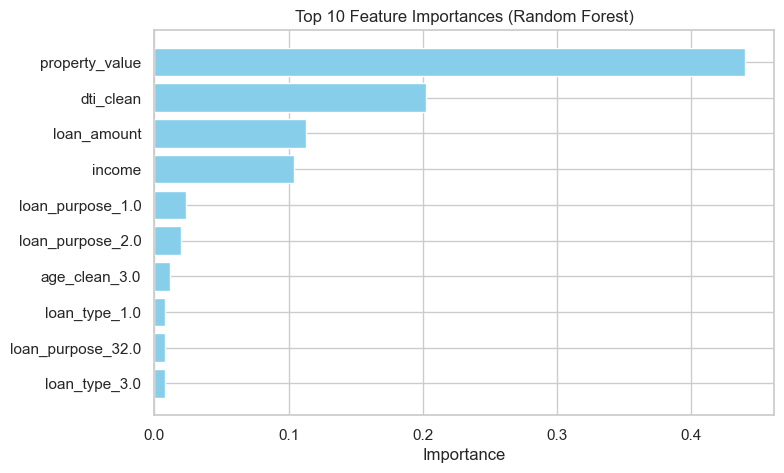

Top 5 features:
property_value: 0.440
dti_clean: 0.202
loan_amount: 0.113
income: 0.104
loan_purpose_1.0: 0.023


In [89]:
# Feature Importance Visualization for Random Forest
import matplotlib.pyplot as plt

# Fit Random Forest on full training set
rf_model_only = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model_only.fit(preprocess.fit_transform(X_train), y_train)

# Feature names after preprocessing
feature_names = (
    numeric +
    list(preprocess.named_transformers_['cat']['onehot'].get_feature_names_out(categorical))
)

# Feature importances
importances = rf_model_only.feature_importances_

# Plot top 10 features
indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(8,5))
plt.barh(range(len(indices))[::-1], importances[indices], color="skyblue")
plt.yticks(range(len(indices))[::-1], [feature_names[i] for i in indices])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

# Print top features
print("Top 5 features:")
for i in indices[:5]:
    print(f"{feature_names[i]}: {importances[i]:.3f}")


## Error Analysis & Failure Modes

In [274]:
# Analyze Misclassifications for Random Forest

import pandas as pd
import numpy as np

# Predict on test set
y_pred = rf.predict(X_test)

# Identify misclassifications
errors = X_test.copy()
errors['y_true'] = y_test
errors['y_pred'] = y_pred
errors['correct'] = errors['y_true'] == errors['y_pred']

# Summary counts
total_errors = (~errors['correct']).sum()
total_samples = len(errors)
print(f"Total test samples: {total_samples}")
print(f"Total misclassifications: {total_errors}")
print(f"Error rate: {total_errors/total_samples:.2%}\n")

# False Positives / False Negatives
fp = errors[(errors['y_true'] == 0) & (errors['y_pred'] == 1)]
fn = errors[(errors['y_true'] == 1) & (errors['y_pred'] == 0)]

print(f"False Positives (predicted 1 but true 0): {len(fp)}")
print(f"False Negatives (predicted 0 but true 1): {len(fn)}\n")

# Ex


Total test samples: 1802
Total misclassifications: 319
Error rate: 17.70%

False Positives (predicted 1 but true 0): 211
False Negatives (predicted 0 but true 1): 108

